In [21]:
# Import Pytorch
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, Normalize, RandomCrop, RandomVerticalFlip, RandomRotation, ConvertImageDtype, AutoAugment, AutoAugmentPolicy
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

# Plotting utils
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

# Get rid of annoying warnings
warnings.filterwarnings("ignore")


# Resnet in Pytorch

This is an attempt to impliment the exact resnet as described in the paper "Deep Residual Learning for Image Recognition" by He et al. (2015). The goal is to do so in a concise "Pytorch" way and test on CIFAR-10 data. (Or maybe Imagenet and Fashion MNIST as well)



## The Data

In [32]:
# Transform data like paper (page 7):
# Horizontal Flip follow by a random crop with a padding of 4, mean subtracted
def make_transforms(mean=0.4739, std=0.2515):
    tt = [RandomHorizontalFlip(), RandomCrop(32, padding=4),
          ToTensor(), Normalize(mean=mean, std=std)]
    #tt = [ToTensor(), ConvertImageDtype(dtype=torch.uint8), AutoAugment(AutoAugmentPolicy.CIFAR10), ConvertImageDtype(dtype=torch.float32), Normalize(mean=mean, std=std)]
    #vt = [ToTensor(), Normalize(mean=mean, std=std)]
    vt = [ToTensor(), Normalize(mean=mean, std=std)]
    train_transforms = Compose(tt)
    valid_transforms = Compose(vt)

    return train_transforms, valid_transforms

# The CIFAR-10 dataset, see "CIFAR-10 and Analysis" on page 7


class CIFAR10:
    def __init__(self, batch_size=64, mean=0.4739, std=0.2515) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(mean, std)
        self.train = datasets.CIFAR10(
            root='data', train=True, transform=train_transforms)
        self.val = datasets.CIFAR10(
            root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = DataLoader(
            self.train, batch_size=batch_size, shuffle=True)
        self.val_dl = DataLoader(self.val, batch_size=batch_size, shuffle=True)


### Subtract mean

In [33]:
# Get mean from data
data = CIFAR10(batch_size=4096*4*2*2)

for x, y in data.train_dl:
    train_mean = x.mean()
    train_std = x.std()

for x, y in data.val_dl:
    val_mean = x.mean()
    val_std = x.std()


cifar_mean = (len(data.train)*train_mean + len(data.val)
              * val_mean)/(len(data.train) + len(data.val))

cifar_std = (len(data.train)*train_std + len(data.val)
              * val_std)/(len(data.train) + len(data.val))

print(f'CIFAR-10 data has total mean across train + val of: {cifar_mean:.4f}')
print(f'CIFAR-10 data has total std across train + val of: {cifar_std:.4f}')


data = CIFAR10(batch_size=4096*4*2*2)#, mean=cifar_mean, std = cifar_std)

for x, y in data.train_dl:
    train_mean = x.mean()
    train_std = x.std()

for x, y in data.val_dl:
    val_mean = x.mean()
    val_std = x.std()

print(
    f'After subtracting the mean for training is {train_mean:.4f} and validation is {val_mean:.4f}')
print(
    f'After subtracting the std for training is {train_std:.4f} and validation is {val_std:.4f}')


CIFAR-10 data has total mean across train + val of: -0.2176
CIFAR-10 data has total std across train + val of: 1.1016
After subtracting the mean for training is -0.2625 and validation is 0.0107
After subtracting the std for training is 1.1225 and validation is 0.9989


### Visualize Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

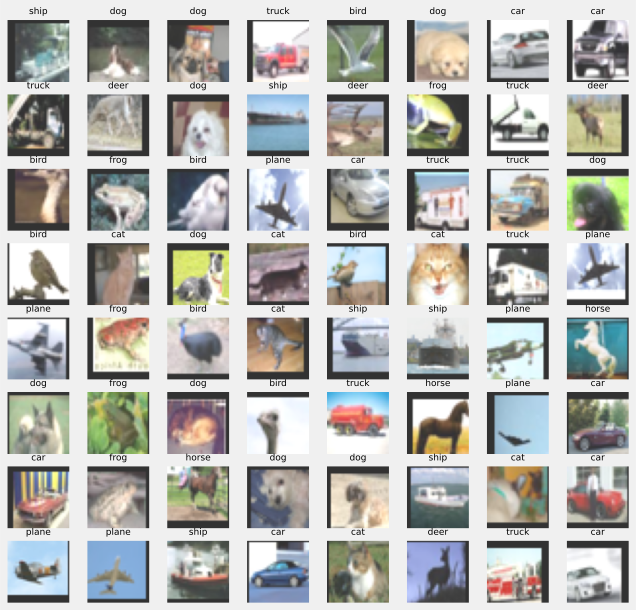

In [34]:
# Check out dataset
def plot_data_check(data, labels, title):
    plt.figure(figsize=(10, 10))
    x, y = next(iter(data.train_dl))

    for i in range(64):

        plt.subplot(8, 8, i+1)
        img = x.permute(0, 2, 3, 1)
        plt.imshow(img[i])
        plt.title(labels[y[i].item()], fontsize=9)
        plt.axis('off')


# CIFAR-10 Data
data = CIFAR10(batch_size=64, mean=cifar_mean, std = cifar_std)

labels = ['plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")


## The ResNet Network

In [35]:
# Initial convolution layer for "main resnet" models
class InitConvLayer7(nn.Module):
    '''Initial convolution layer for "main resnet" models

    All of the "main resnet" models start with a 7x7 kernel with
    64 output channels and a stride of 2 followed by a 3x3 max pool
    stride 2.  See table 1 page 5.'''

    def __init__(self, out_channels: int = 64, kernel_size: int = 7, stride: int = 2, padding: int = 3) -> None:
        super().__init__()
        self.layer = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU())

    def forward(self, x):
        return self.layer(x)


# Initial convolution layer for CIFAR-10 resnet models
class InitConvLayer3(nn.Module):
    '''Initial convolution layer for CIFAR-10 resnet models

    The CIFAR-10 resnet network starts with a 3x3 convolution with 16 channels and 
    a resulting 32x32 image which sets the padding and stride to 1. See page 7.'''

    def __init__(self, out_channels: int = 16, kernel_size: int = 3, stride: int = 1, padding: int = 1, bias=False) -> None:
        super().__init__()
        self.layer = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels), nn.ReLU()
        )

    def forward(self, x):
        return self.layer(x)


# Final layer for resnet models
class FinalLayer(nn.Module):
    '''Final layer for resnet models

    The final layer for both the main and CIFAR resnet models have an AvgPool to 1x1 image
    followed by a Linear layer to output classes.'''

    def __init__(self, num_classes: int = 10, avg_output_size: tuple = (1, 1)) -> None:
        super().__init__()
        self.layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=avg_output_size),
            nn.Flatten(),
            nn.LazyLinear(out_features=num_classes)
        )

    def forward(self, x):
        return self.layer(x)

class ResiduleBlock(nn.Module):
    def __init__(self, out_channels, stride=1, do_conv=True) -> None:
        super().__init__()
        self.conv1 = nn.LazyConv2d(
            out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.do_conv = do_conv
        if self.do_conv:
            self.conv3 = nn.LazyConv2d(
                out_channels, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.do_conv:
            x = self.bn3(self.conv3(x))
        out += x
        return torch.relu(out)


# Main resnet model class
class Resnet(nn.Module):
    '''Main resnet model

    Resnets are of the form Initial Layer, Intermediate Residual Blocks, Final output layer.
    See Table 1 and page 7. The initial block depends on whether it's the CIFAR or main network.
    Sometimes bottleneck blocks are desired (Resnet50+). And we need to know the intermediate 
    repeat lengths for Residual block each time.'''

    def __init__(self, intermediate_lengths: list = [3, 2, 2], cifar: bool = True, bottleneck: bool = False) -> None:
        super().__init__()

        # Initial resnet layer
        if cifar:
            self.init_layer = InitConvLayer3()
        else:
            self.init_layer = InitConvLayer7()

        # Intermediate layers
        intermediate_layers = []
        for length in intermediate_lengths:
            if bottleneck:
                pass
        self.intermediate = nn.Sequential(
            ResiduleBlock(16, do_conv=False), ResiduleBlock(16, do_conv=False), ResiduleBlock(16, do_conv=False),
            ResiduleBlock(32, stride=2), ResiduleBlock(32, do_conv=False), ResiduleBlock(32, do_conv=False),
            ResiduleBlock(64, stride=2), ResiduleBlock(64, do_conv=False), ResiduleBlock(64, do_conv=False),
        )

        # Final output layer
        self.output_layer = FinalLayer()

    def forward(self, x):
        x = self.init_layer(x)
        x = self.intermediate(x)
        x = self.output_layer(x)
        return x


In [17]:
# Test the network seems to do the right thing
x, y = next(iter(data.train_dl))
model = Resnet()
print(f'\nInput x shape is: \n\t{x.shape}')
print(f'\nFinal output shape from model is: \n\t{model(x).shape}')


Input x shape is: 
	torch.Size([64, 3, 32, 32])

Final output shape from model is: 
	torch.Size([64, 10])


## The Trainer Class

Like Pytorch Lightning but better



In [40]:
class Trainer:
    def __init__(self, model, train_dl, val_dl=None, device="cpu", lr=0.1, epoch_update=1, step_update=-1, train_lr=True, num_vals=25, max_epochs=25, schedule=True, seed=-1) -> None:
        self.model = model.to(device)
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.scheduler = None
        self.device = device
        self.step_update = step_update
        self.epoch_update = epoch_update
        self.num_vals = num_vals
        self.max_epochs = max_epochs
        self.lr = lr
        self.schedule = schedule
        self.optimizer = self.configure_optimizer(lr=self.lr)
        self.loss_fn = self.configure_loss_fn()
        self.scheduler = self.configure_scheduler((self.max_epochs + 1))

        # If we are training the learning rate
        self.train_lr = train_lr
        if self.train_lr:
            N = len(self.train_dl)
            self.lrs = torch.logspace(-6, 0, N)

    def configure_scheduler(self, sepoch):
        return CosineAnnealingLR(self.optimizer,
                                 T_max=sepoch, verbose=False)

    def configure_loss_fn(self):
        return nn.CrossEntropyLoss()

    def training_step(self, batch):
        # Get batch
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)

        # Get loss
        train_logits = model(x)
        train_loss = self.loss_fn(train_logits, y)

        return train_loss

    def validation_step(self, batch):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)

        # Get loss
        val_logits = model(x)
        val_loss = self.loss_fn(val_logits, y)
        val_acc = self.accuracy(val_logits, y)

        return val_loss.item(), val_acc.item()

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

    def configure_optimizer(self, lr, momentum=0.9, weight_decay=5e-4, type='SGD'):
        # AdamW and SGD seem to be the most popular. Use them or write your own.
        if type == 'AdamW':
            optimizer = torch.optim.AdamW(
                model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.SGD(
                model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

        return optimizer

    def fit(self):

        # Initial model statistics
        batch = next(iter(data.train_dl))
        train_loss = self.training_step(batch).item()
        print(f'* Fitting model "{self.model.__class__.__name__}" with {sum([p.numel() for p in self.model.parameters()])}.')
        atrain_loss, aval_loss, aval_acc, epoch_str = self.model_stats(0)
        print(epoch_str)

        # Loop over epochs
        train_losses = [atrain_loss]
        val_losses = [aval_loss]
        val_accs = [aval_acc]
        epochs = [0]
        losses = []
        for epoch in range(1, self.max_epochs+1):

            # Training loop
            model.train()
            for step, batch in enumerate(self.train_dl):

                # Training Loss
                train_loss = self.training_step(batch)

                # Update
                self.optimizer.zero_grad(set_to_none=True)
                train_loss.backward()
                self.optimizer.step()

                # If finding optimal learning rate
                if self.train_lr:
                    self.optimizer = self.configure_optimizer(
                        lr=self.lrs[step])
                    losses.append(train_loss.item())

                # If printing stats for each step
                if self.step_update > 1 and step % self.step_update == 0:
                    step_str = f'Step {step:>3d} has train loss {train_loss.item():.4f}.'
                    print(step_str)

            if self.train_lr:
                break

            # Step scheduler
            if self.schedule:
                self.scheduler.step()

                #if epoch == int(0.5*self.max_epochs)+1 or epoch == int(0.75*self.max_epochs)+1:
                #    self.lr = self.lr/10.
                #    self.optimizer = self.configure_optimizer(lr=self.lr)
                #    sepoch = int(self.max_epochs*0.25)+1
                #    # print (f'epoch for schedular is {epoch} with Tmax {self.sepoch }')
                #    self.scheduler = self.configure_scheduler(sepoch)

            # Get model statistics on desired epochs
            if epoch % self.epoch_update == 0 or epoch == self.max_epochs:
                epochs.append(epoch)
                atrain_loss, aval_loss, aval_acc, ep_str = self.model_stats(
                    epoch)
                train_losses.append(atrain_loss)
                val_losses.append(aval_loss)
                val_accs.append(aval_acc)
                print(ep_str)

        if self.train_lr:
            self.plot_lrs(self.lrs, losses)
        else:
            self.plot_results(train_losses, val_losses, val_accs, epochs)

    def model_stats(self, epoch):
        # Training loss and validation loss and accuracy
        model.eval()
        with torch.no_grad():
            avg_train_loss = 0.0
            avg_val_loss = 0.0
            avg_val_acc = 0.0
            norm = len(self.val_dl)
            for tbatch, vbatch in zip(self.train_dl, self.val_dl):
                # Average training Loss
                train_loss = self.training_step(tbatch).item()
                avg_train_loss += train_loss

                # Average validation loss
                val_loss, val_acc = self.validation_step(vbatch)
                avg_val_loss += val_loss
                avg_val_acc += val_acc

            avg_train_loss = avg_train_loss/norm
            avg_val_loss = avg_val_loss/norm
            avg_val_acc = avg_val_acc/norm

            lri = self.scheduler.get_last_lr()[-1]
            epoch_str = f'Epoch {epoch:>3d}: lr {lri:.5f}, '
            epoch_str += f'train_loss {avg_train_loss:.4f}, '
            epoch_str += f'val_loss {avg_val_loss:.4f}, '
            epoch_str += f'and accuracy {avg_val_acc:.4f}'

        return avg_train_loss, avg_val_loss, avg_val_acc, epoch_str

    def plot_results(self, train_losses, val_losses, val_accs, epochs):
        plt.figure()
        plt.plot(epochs, train_losses, 'C0-',
                 label=f'Training {train_losses[-1]:.2f}')
        plt.plot(epochs, val_losses, 'C1--',
                 label=f'Validation {val_losses[-1]:.2f}')
        plt.plot(epochs, val_accs, 'C2:', label=f'Accuracy {val_accs[-1]:.2f}')
        plt.ylim(0, 1.2)
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()

    def plot_lrs(self, lrs, losses):
        plt.figure()
        plt.semilogx(lrs, losses)
        plt.xlabel('Learning Rates')
        plt.ylabel('Losses')
        plt.show()


In [41]:
class DoubleLinear(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(
            128), nn.ReLU(), nn.LazyLinear(num_classes))

    def forward(self, x):
        return self.net(x)


* Fitting model "Resnet" with 272954.
Epoch   0: lr 0.01000, train_loss 2.3055, val_loss 2.3059, and accuracy 0.0996
Epoch   5: lr 0.00996, train_loss 0.7873, val_loss 0.8241, and accuracy 0.7167
Epoch  10: lr 0.00985, train_loss 0.5645, val_loss 0.6443, and accuracy 0.7850
Epoch  15: lr 0.00967, train_loss 0.4657, val_loss 0.5796, and accuracy 0.8067
Epoch  20: lr 0.00942, train_loss 0.3682, val_loss 0.5063, and accuracy 0.8299
Epoch  25: lr 0.00910, train_loss 0.3259, val_loss 0.4614, and accuracy 0.8435
Epoch  30: lr 0.00872, train_loss 0.3054, val_loss 0.4386, and accuracy 0.8520
Epoch  35: lr 0.00829, train_loss 0.2700, val_loss 0.4343, and accuracy 0.8605
Epoch  40: lr 0.00781, train_loss 0.2764, val_loss 0.4782, and accuracy 0.8475
Epoch  45: lr 0.00729, train_loss 0.2219, val_loss 0.4347, and accuracy 0.8610
Epoch  50: lr 0.00673, train_loss 0.1889, val_loss 0.3967, and accuracy 0.8769
Epoch  55: lr 0.00615, train_loss 0.2070, val_loss 0.4123, and accuracy 0.8696
Epoch  60: lr 

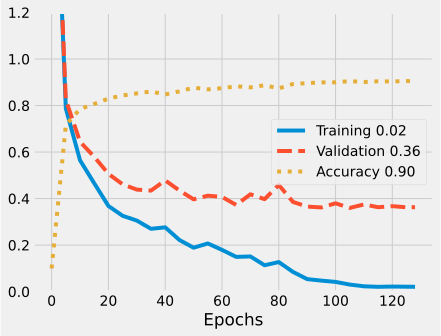

In [42]:
for seed in [1337]:
    # Reproducability
    torch.manual_seed(1337)

    # Data
    data = CIFAR10(batch_size=128, mean=cifar_mean, std = cifar_std)

    # Model
    model = Resnet()
    #model = DoubleLinear()

    # Trainer
    trainer = Trainer(model, data.train_dl, data.val_dl, lr=0.01, device = "mps", 
                  epoch_update=5, train_lr=False, schedule=True, max_epochs=128)
    trainer.fit()


In [ ]:
# Try 512 batchsize next